# Feedforward Neural Network with PyTorch on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
By [Zahra Taheri](https://github.com/zahta), October 7, 2020

## Import libraries

In [1]:
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt

## Download the Fashion-MNIST dataset by Torchvision

In [2]:
train = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test = dsets.FashionMNIST(root='./data',
                                   train=False,
                                   transform=transforms.ToTensor()
                                 )

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


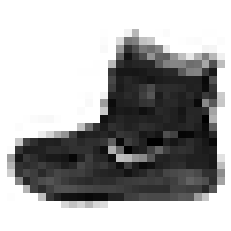

In [3]:
some_digit = train[0][0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [4]:
imgs = torch.stack([img_t for img_t, _ in train], dim=3)
imgs.shape

torch.Size([1, 28, 28, 60000])

In [5]:
mean = imgs.view(1, -1).mean(dim=1)
mean

tensor([0.2859])

In [6]:
std = imgs.view(1, -1).std(dim=1)
std

tensor([0.3530])

**Note:**  If we use the following cell to download the Fashion-MNIST dataset, then train and test sets will be split with a ratio of **86 : 14**, because the train_dataset size is 60000 and the test_dataset size is 10000.

In [7]:
my_transforms = transforms.Compose([transforms.Resize(28),
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean),(std))
                                   ])

train_dataset = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=my_transforms,
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                                   train=False,
                                   transform=my_transforms
                                 )

In [8]:
print(len(train_dataset))

print(len(test_dataset))

60000
10000


In [9]:
imgs2 = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
imgs2.shape

torch.Size([1, 28, 28, 60000])

In [10]:
mean2 = imgs2.view(1, -1).mean(dim=1)
mean2

tensor([5.8678e-05])

In [11]:
std2 = imgs2.view(1, -1).std(dim=1)
std2

tensor([1.])

#### If we want to have a train set and a test set with the desired ratio in their sizes, we may use the following code blocks:
- It must be noted that if we use `torch.utils.data.random_split` to split a train set and a test set, then the number of samples per class is not guaranteed to be balanced. So, we use the following codes to have balanced train and test sets.
- In order to have a train set and a test set with the ratio 70 : 30, the train and test set sizes should be $\frac{70\times 70000}{100}=49000$ and $70000-49000=21000$, respectively, because the full data size is $70000$.

In [12]:
#desired ratio for train set
train_r = 70 # train_r% of the data will be considered as a train set

train_size = (train_r * (train_dataset.targets.size()[0] + test_dataset.targets.size()[0])) / 100

# the number of each class in a balanced training set
k = train_size / 10  #labels of Fashin-MNIST are from 10 classes

In [13]:
from torch.utils.data import TensorDataset

def SampleFromEachClass(dataset, test_dataset, k):
    
    dict_cl_count = {}
    train_data = []
    train_label = []
    test_data = []
    test_label = []
    
    for data, label in test_dataset:
        test_data.append(data)
        test_label.append(label)
            
    for data, label in dataset:
        dict_cl_count[label] = dict_cl_count.get(label, 0) + 1
        if dict_cl_count[label] <= k:
            train_data.append(data)
            train_label.append(label)
        else:
            test_data.append(data)
            test_label.append(label)
    
    train_data = torch.cat(train_data)
    train_label = torch.Tensor(train_label)
    train_label = train_label.type(torch.LongTensor)
    
    test_data = torch.cat(test_data)
    test_label = torch.Tensor(test_label)
    test_label = test_label.type(torch.LongTensor)
    
    print("train set size:", train_data.size())
    print("test set size:", test_data.size())
    return (TensorDataset(train_data, train_label), 
            TensorDataset(test_data, test_label))

In [14]:
train_ds, test_ds = SampleFromEachClass(train_dataset, test_dataset, k)

train set size: torch.Size([49000, 28, 28])
test set size: torch.Size([21000, 28, 28])


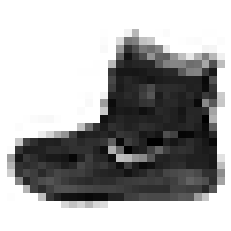

In [15]:
some_digit = train_ds[0][0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [16]:
imgs3 = torch.stack([img_t for img_t, _ in train_ds], dim=2)
imgs3.shape

torch.Size([28, 28, 49000])

In [17]:
mean3 = imgs3.view(1, -1).mean(dim=1)
std3 = imgs3.view(1, -1).std(dim=1)
mean3, std3

(tensor([-0.0011]), tensor([0.9994]))

## Sequential Model

In [18]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 100 
hidden_dim4 = 100 
hidden_dim5 = 100 

In [19]:
import torch.nn as nn
from torch.autograd import Variable

seq_model = nn.Sequential(
        nn.Linear(input_dim,hidden_dim1),
        nn.ReLU(),
        nn.Linear(hidden_dim1,hidden_dim2),
        nn.ReLU(),
        nn.Linear(hidden_dim2,hidden_dim3),
        nn.Sigmoid(),
        nn.Linear(hidden_dim3,hidden_dim4),
        nn.ReLU(),
        nn.Linear(hidden_dim4,hidden_dim5),
        nn.ReLU(),
        nn.Linear(hidden_dim5,output_dim),
)

seq_model

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): Linear(in_features=100, out_features=10, bias=True)
)

In [20]:
#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    seq_model.cuda()

In [21]:
batch_size = 68
n_iters = 11000
num_epochs = n_iters / (len(train_ds) / batch_size)
num_epochs = int(num_epochs)
num_epochs

15

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_ds, batch_size=batch_size,  shuffle=False)

In [23]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(seq_model.parameters(), lr=learning_rate)

In [24]:
# Train the model

iter = 0
for epoch in range(num_epochs):
############################################################################ one iteration
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
               
        # Forward pass to get output/logits
        outputs = seq_model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_fn(outputs, labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
############################################################################ 
        iter += 1
        
        # Test part
        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = seq_model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))

Iteration: 1000. Loss: 0.6536089777946472. Accuracy: 76
Iteration: 2000. Loss: 0.3765571713447571. Accuracy: 84
Iteration: 3000. Loss: 0.7040717601776123. Accuracy: 84
Iteration: 4000. Loss: 0.1822957545518875. Accuracy: 85
Iteration: 5000. Loss: 0.21372495591640472. Accuracy: 86
Iteration: 6000. Loss: 0.33698907494544983. Accuracy: 86
Iteration: 7000. Loss: 0.12149012833833694. Accuracy: 87
Iteration: 8000. Loss: 0.19434210658073425. Accuracy: 87
Iteration: 9000. Loss: 0.262069433927536. Accuracy: 87
Iteration: 10000. Loss: 0.1540425717830658. Accuracy: 87


## Create model class

In [25]:
class FNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Sigmoid()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        
        out = self.f6(out)
        
        return out       
    

In [26]:
model = FNNModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()

In [27]:
batch_size = 68
n_iters = 11000
num_epochs = n_iters / (len(train_ds) / batch_size)
num_epochs = int(num_epochs)
num_epochs

15

In [28]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
# Train the model

iter = 0
for epoch in range(num_epochs):
    # one iteration = 
    #{
    for i, (images, labels) in enumerate(train_loader):
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_fn(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
    #}
        iter += 1
        
        if iter % 1000 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, 28*28).cuda())
                else:
                    images = Variable(images.view(-1, 28*28))    
                    
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
           
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # because .sum() function does not work on GPU
                else:                
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct // total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data, accuracy))

Iteration: 1000. Loss: 0.5843061208724976. Accuracy: 77
Iteration: 2000. Loss: 0.5519556999206543. Accuracy: 82
Iteration: 3000. Loss: 0.3914315700531006. Accuracy: 85
Iteration: 4000. Loss: 0.4388110637664795. Accuracy: 86
Iteration: 5000. Loss: 0.2929420471191406. Accuracy: 86
Iteration: 6000. Loss: 0.3413446247577667. Accuracy: 86
Iteration: 7000. Loss: 0.24496027827262878. Accuracy: 87
Iteration: 8000. Loss: 0.2697722613811493. Accuracy: 88
Iteration: 9000. Loss: 0.19196616113185883. Accuracy: 86
Iteration: 10000. Loss: 0.2889183759689331. Accuracy: 87


In [30]:
torch.save(model.state_dict(), 'FNN-PyTorch-Fashion-MNIST.pkl')# only save parameters